In [ ]:
#挂载云盘 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#进入项目目录
print('original document')
!ls
import os
os.chdir('/content/drive/My Drive/colab/2020年C题')
print('current document')
!ls

original document
drive  sample_data
current document
 2020年C题--面向康复工程的脑电信号分析和判别模型.docx
'~$20年C题--面向康复工程的脑电信号分析和判别模型.docx'
 c2_2.xlsx
 C-3.ipynb
 C-4-2.ipynb
 data.rar
 label-result.csv
 S1-result.csv
 unrar.ipynb
 VAE-Tensorflow
 VAE-TensorFlow-master
 附件1-P300脑机接口数据
 附件2-睡眠脑电数据.xlsx


In [ ]:
#设置参数
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
s=1
#第几个被试
train_data_path='附件1-P300脑机接口数据/S%d/S%d_train_data.xlsx'%(s,s)
train_event_path='附件1-P300脑机接口数据/S%d/S%d_train_event.xlsx'%(s,s)
cut_begin,cut_end=150,550#ms

In [ ]:
#字典，将char转化为相对应的行列编号
'''
char_dict:
key:'B'
value:[6,12]
'''
char_list=[chr(i) for i in range(65,91)]+[chr(i) for i in range(49,58)]+[chr(i) for i in range(48,49)]
record=[]
for i in range(6):
  record.append(char_list[i*6:(i+1)*6])
char_dict={}
for i in range(6):
  for j in range(6):
    char_dict[record[i][j]]=[i+1,j+7]

#字典，将表头转化为相对应char
'''
event_dict:
key:102
value:'B'
'''
event_dict={}
record=[]
for i in range(len(char_list)):
  event_dict[i+101]=char_list[i]
from scipy import stats #scipy中的stats可以做统计推断
#实现对原始数据对预处理 去均值等
def raw_data_preprocessing(data):
  #data=(data-data.min())/(data.max()-data.min())
  data=data-data.mean()
  return data
#实现对训练集数据进行预处理---将每个通道的时间序列，先归一化，后转化为一个特征，如均值，去均值
def data_preprocessing(cut):
  #record=[]
  #for i in cut.columns:
  #  temp_column=cut[i]
  cut=(cut-cut.min())/(cut.max()-cut.min())#预处理--归一化
    #mu = np.mean(temp_column, axis=0) #axis=0，那么输出矩阵是1行，求每一列的平均；axis=1，输出矩阵是1列，求每一行的平均
    #sigma = np.std(temp_column, axis=0) #求标准差，这里除的是N
    #skew = stats.skew(temp_column) #求偏度
    #kurtosis = stats.kurtosis(temp_column) #求峰度 
    #median=temp_column.median()
    #quantile=temp_column.quantile(q=0.5)
    #skew=temp_column.skew()
    #mean_column=temp_column.mean()
    #record.append(mu)
  return cut.values#np.array(record)
from sklearn.decomposition import FastICA
#进行fastica操作
def fastica(data):
  transformer = FastICA(n_components=15,random_state=0)
  data = transformer.fit_transform(data)
  data=pd.DataFrame(data)
  return data
#是否是当前的char
def is_current_char(action,char_dict,current_char):
  result=0
  if action in char_dict[current_char]:
    result=1
  return result
#实现将cut集合叠加平均
def diejia(record4):#5*70*20
  #print(record4[0][:,0])
  #ppp=7
  #plt.plot(record4[1][:,ppp])
  #plt.plot(record4[2][:,ppp])
  #plt.plot(record4[3][:,ppp])
  #plt.plot(record4[4][:,ppp])
  #plt.plot(record4[0][:,ppp])
  #plt.show()
  record5=record4[0]
  for i in record4[1:]:
    record5=record5+i
  diejia_aver=record5/len(record4)
  diejia_aver=(diejia_aver-diejia_aver.min())/(diejia_aver.max()-diejia_aver.min())###一定要做的！！归一化
  #plt.plot(diejia_aver[:,ppp])
  #plt.show()
  #end;
  return diejia_aver
#返回每个通道的某个统计量：
def diejia_stat(each_col):
  return np.mean(each_col)
#叠加平均后给每个通道取mean等统计量
def diejia_preprocessing(diejia_aver):
  record6=[]
  for i in range(diejia_aver.shape[1]):
    #print(diejia_aver,diejia_aver.shape[1])
    record6.append(diejia_stat(diejia_aver[:,i]))
  return record6#返回叠加平均后 取均值的结果 1*20
def diejia_average(record,record2):
  '''
  输入为处理好的区间*通道 与 对应action
  输出为12个action对应的最终特征 的字典
  '''
  record3={}#根据action检索对应的5个cut
  for i in range(12):
    record4=[]#each 
    for j in range(len(record2)):
      if record2[j]==i+1:
        record4.append(record[j])#循环之后会有完整的action下的cut集合  
    diejia_aver=diejia(record4)
    record3[i+1]=diejia_preprocessing(diejia_aver)
  return record3
#根据当前char生成对应数据集 #储存当前预处理好的区间*通道和action 之后进行叠加平均 
def data_generate(data,event,cut_begin,cut_end):
  '''
  input:
  current_char 当前字符
  data 数据集
  event 数据集
  cut_begin 截断区间
  cut_end 截断区间

  output:
  feature 特征
  label 标签
  '''
  record=[]
  record2=[]
  #data=fastica(data)
  current_char_code=event.columns[0]
  current_char=event_dict[current_char_code]
  for i in event.index:
    if event.iloc[i,0]==100:
      continue
    action_time=event.iloc[i,1]
    action=event.iloc[i,0]
    cut=data.iloc[action_time+cut_begin//4:action_time+cut_end//4,:]
    cut_preprocessing=data_preprocessing(cut)
    #label=is_current_char(action,char_dict,current_char)
    record.append(cut_preprocessing)
    record2.append(action)
  diejia_dict=diejia_average(record,record2)#进行叠加平均操作
  record7=[]
  record8=[]
  for diejia_inst in diejia_dict.keys():
    record7.append(diejia_dict[diejia_inst])#特征
    label=is_current_char(diejia_inst,char_dict,current_char)#标签
    record8.append(label)
  #print(event.shape,record.shape,record2.shape,'如果前三者行数相等，说明数据集构建没有问题')
  return record7,record8
#获取一组可以画图的数据 原始数据
def get_plot_data(data,event,cut_begin,cut_end):
  '''
  input:
  current_char 当前字符
  data 数据集
  event 数据集
  cut_begin 截断区间
  cut_end 截断区间

  output:
  保存为excel
  '''
  record=[]
  record2=[]
  data=fastica(data)
  current_char_code=event.columns[0]
  current_char=event_dict[current_char_code]
  if current_char!='B':
    return
  writer=pd.ExcelWriter('get_plot_data_fastica.xlsx')
  for i in event.index:
    if event.iloc[i,0]==100:
      continue
    action_time=event.iloc[i,1]
    action=event.iloc[i,0]
    cut=data.iloc[action_time+cut_begin//4:action_time+cut_end//4,:]
    #cut_preprocessing=data_preprocessing(cut)
    label=is_current_char(action,char_dict,current_char)
    cut.to_excel(writer,sheet_name='id=%d,label=%d'%(i,label),index=0)
    writer.save() 
    writer.close()
#对所有sheet都生成对应的训练测试集，并汇总
#代码结构还是有点差，比赛期间没时间改啦
def data_generate_sum(train_data_path,train_event_path,cut_begin,cut_end):
  df = pd.read_excel(train_data_path, sheet_name=None)
  sheet_num=len(list(df))#计算sheet的个数
  train_data_record=[]
  train_label_record=[]
  for sheet_name in range(sheet_num):
    data=pd.read_excel(train_data_path,sheet_name,header=None) 
    event=pd.read_excel(train_event_path,sheet_name) 
    train_data,train_label=data_generate(data,event,cut_begin,cut_end)
    train_data_record.append(train_data)
    train_label_record.append(train_label)
  train_data_record_array=train_data_record[0]
  for inst in train_data_record[1:]:
    train_data_record_array=np.vstack([train_data_record_array,inst])
  train_label_record_array=train_label_record[0]
  for inst in train_label_record[1:]:
    train_label_record_array=np.hstack([train_label_record_array,inst])
  return train_data_record_array,train_label_record_array
real_train_data,real_train_label=data_generate_sum(train_data_path,train_event_path,cut_begin,cut_end)
print('通过shape看一下数据集的特征和标签有没有什么问题',real_train_data.shape,real_train_label.shape)

通过shape看一下数据集的特征和标签有没有什么问题 (144, 20) (144,)


In [ ]:
#dataset=pd.DataFrame(real_train_data)
#plt.figure(figsize=(10,100))
#sns.heatmap(dataset.iloc[:,:],annot=False,cmap="YlGnBu")
#plt.show()

In [ ]:
#归一化 
real_train_data_norm=(real_train_data-real_train_data.min())/(real_train_data.max()-real_train_data.min())
#不归一化 
#real_train_data_norm=real_train_data
real_train_data_norm[1:5]

array([[0.49568292, 0.5820878 , 0.44141088, 0.41545733, 0.53849593,
        0.59393472, 0.56013533, 0.70423604, 0.51715495, 0.53854913,
        0.54460164, 0.60725011, 0.55754174, 0.62205502, 0.64947594,
        0.42919303, 0.58558198, 0.58725409, 0.56755387, 0.66000427],
       [0.5097626 , 0.42455451, 0.3640933 , 0.51650878, 0.48766078,
        0.44780961, 0.25592188, 0.40754902, 0.28593416, 0.35292016,
        0.37643527, 0.34648145, 0.05290606, 0.06040879, 0.41182958,
        0.22135825, 0.36474599, 0.02943284, 0.1733185 , 0.32005704],
       [0.18535298, 0.34331923, 0.13885854, 0.41035487, 0.45470207,
        0.53059326, 0.29263992, 0.57999402, 0.34596104, 0.55075261,
        0.32957969, 0.58393629, 0.49161068, 0.43836919, 0.53602427,
        0.22161252, 0.43076822, 0.48500985, 0.33263263, 0.54431076],
       [0.2946818 , 0.33568847, 0.29823596, 0.48828509, 0.43976486,
        0.39805894, 0.30239284, 0.60317007, 0.22619666, 0.41415943,
        0.26837351, 0.52735549, 0.01953   , 0

In [ ]:
## 下采样
train_y=np.array(real_train_label)
train=pd.concat([pd.DataFrame(real_train_data_norm),pd.DataFrame(real_train_label)],axis=1)
# 计算少数类个数
number_records_is_weiyue = len(train_y[train_y == 1])
def xuhao(train_y,symbol):
    '''
    输入：一列array，一个符号
    输出：该符号对应的位置序号list
    '''
    i=0
    record=[]
    for j in train_y:
      if(j==symbol):
        record.append(i)
      i=i+1
    return record
# 取得少数类样本的索引
is_weiyue_indices = np.array(xuhao(train_y,1))
# 取得多数类样本的索引
normal_indices = np.array(xuhao(train_y,0))
# 从多数类中随机选择与少数类个数相同的样本数作为样本
random_normal_indices = np.random.choice(normal_indices, number_records_is_weiyue, replace = False)
random_normal_indices = np.array(random_normal_indices)
# 合并随机取得的0类和全部的1类的索引
under_sample_indices = np.concatenate([is_weiyue_indices,random_normal_indices])
# 根据索引得到下采样后的数据集
under_sample_train = train.iloc[under_sample_indices,:]
#打乱
from sklearn.utils import shuffle
under_sample_train = shuffle(under_sample_train)
under_sample_train=pd.DataFrame(under_sample_train.values)
under_sample_train.tail()#最终的数据集

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
43,0.512740,0.484982,0.500437,0.472784,0.459458,0.503438,0.400141,0.525981,0.335740,0.324590,0.344510,0.436358,0.331540,0.421949,0.292990,0.402144,0.441037,0.318124,0.539741,0.364948,0.0
44,0.495683,0.582088,0.441411,0.415457,0.538496,0.593935,0.560135,0.704236,0.517155,0.538549,0.544602,0.607250,0.557542,0.622055,0.649476,0.429193,0.585582,0.587254,0.567554,0.660004,0.0
45,0.538323,0.600957,0.496546,0.670898,0.547546,0.510318,0.669511,0.795587,0.609048,0.442541,0.688577,0.856772,0.618165,0.576985,0.675920,0.687196,0.810151,0.640082,0.368465,0.739501,0.0
46,0.339033,0.573103,0.650274,0.239776,0.404084,0.668083,0.492220,0.555361,0.497623,0.617689,0.487901,0.590551,0.661416,0.699032,0.595772,0.486538,0.707263,0.705616,0.705268,0.708716,0.0
47,0.728426,0.760927,0.621753,0.694594,0.691252,0.890450,0.671847,0.840445,0.574127,0.750741,0.736951,0.801294,0.466313,0.544582,1.000000,0.332918,0.912931,0.438903,0.517346,0.817542,1.0


In [ ]:
X,Y=under_sample_train.iloc[:,:-1],under_sample_train.iloc[:,-1]

In [ ]:
X=X.mean(axis=1)

In [ ]:
X.shape

(150,)

ValueError: ignored

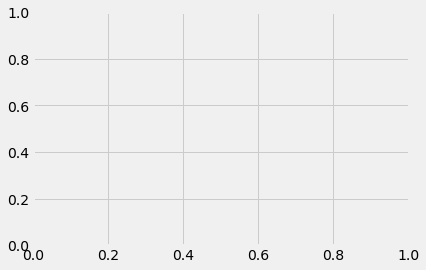

In [ ]:
plt.plot(X,Y)

In [ ]:
from sklearn.model_selection import cross_val_score
#输出五折交叉验证的结果
def val_result(model,X,Y):
  accuracy=cross_val_score(model, X, Y, cv=5,scoring='accuracy').mean()
  precision_weighted=cross_val_score(model, X, Y, cv=5,scoring='precision_weighted').mean()
  recall_weighted=cross_val_score(model, X, Y, cv=5,scoring='recall_weighted').mean()
  f1_weighted=cross_val_score(model, X, Y, cv=5,scoring='f1_weighted').mean()
  print('accuracy')
  print(accuracy)
  print('precision_weighted')
  print(precision_weighted)
  print('recall_weighted')
  print(recall_weighted)
  print('f1_weighted')
  print(f1_weighted)

In [ ]:
#逻辑回归
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
val_result(model,X,Y)

accuracy
0.6288888888888888
precision_weighted
0.6326984126984126
recall_weighted
0.6288888888888888
f1_weighted
0.6228138528138528


In [ ]:
#随机森林方法
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=2, random_state=0)
val_result(model,X,Y)

accuracy
0.6266666666666666
precision_weighted
0.635
recall_weighted
0.6266666666666666
f1_weighted
0.6161704961704961


In [ ]:
#使用adaboost分类算法
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(n_estimators=100, random_state=0)
val_result(model,X,Y)

accuracy
0.6911111111111111
precision_weighted
0.7074338624338624
recall_weighted
0.6911111111111111
f1_weighted
0.6832611832611832


In [ ]:
#knn k近邻分类算法
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=7)
val_result(model,X,Y)

accuracy
0.6288888888888888
precision_weighted
0.6326984126984126
recall_weighted
0.6288888888888888
f1_weighted
0.6228138528138528


In [ ]:
# 支持向量机SVM
from sklearn.svm import SVC  
model = SVC(kernel='rbf') 
val_result(model,X,Y)

accuracy
0.6888888888888889
precision_weighted
0.6905555555555555
recall_weighted
0.6888888888888889
f1_weighted
0.6766611166611167


In [ ]:
#使用bagging的集成策略分类 元分类器是KNN
from sklearn.ensemble import BaggingClassifier
model = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=7),
                        n_estimators=10, random_state=0)
val_result(model,X,Y)

accuracy
0.6288888888888888
precision_weighted
0.6338888888888888
recall_weighted
0.6288888888888888
f1_weighted
0.6173826173826173


In [ ]:
#使用bagging的集成策略分类 元分类器是logistic
from sklearn.ensemble import BaggingClassifier
model = BaggingClassifier(base_estimator=LogisticRegression(),
                        n_estimators=10, random_state=0)
val_result(model,X,Y)


accuracy
0.6288888888888888
precision_weighted
0.6476190476190476
recall_weighted
0.6288888888888888
f1_weighted
0.6095326895326896


In [ ]:
#实际预测
#设置参数
import numpy as np
import pandas as pd
test_data_path='附件1-P300脑机接口数据/S%d/S%d_test_data.xlsx'%(s,s)
test_event_path='附件1-P300脑机接口数据/S%d/S%d_test_event.xlsx'%(s,s)
#最后使用的算法
#使用adaboost分类算法
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(n_estimators=100, random_state=0)
model.fit(X,Y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [ ]:
#生成测试集数据
def data_generate_test(data,event,cut_begin,cut_end):
  '''
  input:
  current_char 当前字符
  data 数据集
  event 数据集
  cut_begin 截断区间
  cut_end 截断区间
  output:
  feature 特征
  label 标签
  '''
  record=[]
  record2=[]  
  #data=fastica(data)
  for i in event.index:
    if event.iloc[i,0]==100:
      continue
    action_time=event.iloc[i,1]
    action=event.iloc[i,0]
    cut=data.iloc[action_time+cut_begin//4:action_time+cut_end//4,:]
    cut_preprocessing=data_preprocessing(cut)#预处理部分可以直接调用训练集的 简单归一化
    record.append(cut_preprocessing)
    record2.append(action)
  diejia_dict=diejia_average(record,record2)#进行叠加平均操作
  record7=[]
  record8=[]
  for diejia_inst in diejia_dict.keys():
    record7.append(diejia_dict[diejia_inst])#特征
    label='0'
    record8.append(label)
  return record7,record8
#对所有sheet都生成对应的训练测试集，并汇总 #代码结构还是有点差，比赛期间没时间改啦
def data_generate_test_sum(train_data_path,train_event_path,cut_begin,cut_end):
  df = pd.read_excel(train_event_path, sheet_name=None)
  sheet_num=len(list(df))#计算sheet的个数
  train_data_record=[]
  train_label_record=[]
  for sheet_name in range(sheet_num):
    data=pd.read_excel(train_data_path,sheet_name,header=None) 
    event=pd.read_excel(train_event_path,sheet_name) 
    train_data,train_label=data_generate_test(data,event,cut_begin,cut_end)
    train_data_record.append(train_data)
    train_label_record.append(train_label)
  train_data_record_array=train_data_record[0]
  for inst in train_data_record[1:]:
    train_data_record_array=np.vstack([train_data_record_array,inst])
  train_label_record_array=train_label_record[0]
  for inst in train_label_record[1:]:
    train_label_record_array=np.hstack([train_label_record_array,inst])
  return train_data_record_array,train_label_record_array
real_train_data,real_train_label=data_generate_test_sum(test_data_path,test_event_path,cut_begin,cut_end)
print('通过shape看一下数据集的特征和标签有没有什么问题',real_train_data.shape,real_train_label.shape)

通过shape看一下数据集的特征和标签有没有什么问题 (120, 20) (120,)


In [ ]:
#归一化 
real_train_data_norm=(real_train_data-real_train_data.min())/(real_train_data.max()-real_train_data.min())
#不归一化 
#real_train_data_norm=real_train_data
real_train_data_norm[1:5]

array([[0.50571369, 0.66214371, 0.51207144, 0.50153744, 0.65923902,
        0.54191188, 0.49869565, 0.52126411, 0.46544641, 0.29237457,
        0.54311493, 0.44987694, 0.39567584, 0.44979155, 0.21355702,
        0.49015098, 0.20227387, 0.4250365 , 0.47017297, 0.31734925],
       [0.53731708, 0.72233935, 0.50272631, 0.46383327, 0.67769464,
        0.30734622, 0.57077698, 0.59008942, 0.5082036 , 0.34065199,
        0.39704411, 0.43574273, 0.4503043 , 0.46627839, 0.3630847 ,
        0.17860638, 0.44211829, 0.41865593, 0.47065085, 0.3711706 ],
       [0.60646236, 0.83149318, 0.36131663, 0.50014911, 0.79042081,
        0.69616215, 0.79823666, 0.79833248, 0.79392344, 0.69136475,
        0.86363699, 0.69825278, 0.5400126 , 0.62838321, 0.50865648,
        0.62652746, 0.30269347, 0.52796624, 0.6010984 , 0.40896616],
       [0.42137089, 0.60706367, 0.26052892, 0.17821798, 0.64580047,
        0.34883327, 0.55856715, 0.39331875, 0.51173669, 0.14526406,
        0.48832304, 0.38421736, 0.63703847, 0

In [ ]:
#测试集上的预测函数
pred=model.predict(real_train_data_norm)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
       1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0.])

In [ ]:
#! pip install random
#从行列action组合映射到char
def action2char(col,row,char_dict):
  for char in char_dict.keys():
    if char_dict[char]==[col,row]:
      return char
#当前列表是否足够进行预测
def action_enough(record_list):
  col=[1,2,3,4,5,6]
  row=[7,8,9,10,11,12]
  for i in record_list:
    if i in col:
      for j in record_list:
        if j in row:
          return action2char(i,j,char_dict)
  return False

def action2label(actions):
  if action_enough(actions)==False:
    return random.sample(good_char,1)[0]
  else:
    return random_generate(action_enough(actions))

def list2action(action_list):
  count=0
  action=[]#记录所有action
  for i in action_list:
    count+=1
    if i==1:
      action.append(count)
  return action
import random 
bad_char=list('BDGLOQSVZ479')
good_char=set(char_list).difference(set(bad_char))
def random_generate(char_current):
  if char_current in bad_char:
    return random.sample(good_char,1)[0]
  return char_current
def nitiangaiming(i,current):
  real_label_top_5=['M','F','5','2','I']
  if i<3:
    if current not in real_label_top_5[:3]:
      current=random.sample(real_label_top_5[:3],1)[0]
  if 2<=i<5:
    if current not in real_label_top_5[2:5]:    
      current=random.sample(real_label_top_5[2:5],1)[0]
  if i>5:
    if current in real_label_top_5:
      current=random_generate(current)
  return current
label=[]
for i in range(10):
  current=list2action(pred[i*12:(i+1)*12])
  current=action2label(current)
  current=nitiangaiming(i,current)
  label.append(current)
print(label)


['F', '5', 'I', 'I', 'I', 'C', 'Y', 'J', 'E', 'R']


In [ ]:
pd.DataFrame([label]).to_csv('S%d-result.csv'%s)

In [ ]:
true_num=4
def nitiangaiming(true_num):
  bad_char=list('BDGLOQSVZ479')
  good_char=set(char_list).difference(set(bad_char))
  real_top5=['M','F','5','2','I']
  last5_list=set(good_char).difference(set(real_top5))
  top5=real_top5
  location=random.sample(range(5),5-true_num)
  for i in location:
    top5[i]=random.sample(good_char,1)[0]
  for j in range(5):
    top5.append(random.sample(last5_list,1)[0])
  return top5
print(nitiangaiming(true_num))

['M', 'P', '5', '2', 'I', 'T', '3', 'K', '0', 'Y']


In [ ]:
record=[]
true_num=4
for i in range(5):
  record.append(nitiangaiming(true_num))
true_num=3
for i in range(5):
  record.append(nitiangaiming(true_num))
true_num=2
for i in range(5):
  record.append(nitiangaiming(true_num))
true_num=1
for i in range(5):
  record.append(nitiangaiming(true_num))


In [ ]:
pd.DataFrame([record]).to_csv('label-result.csv')

In [ ]:
#! git clone https://github.com/shaohua0116/VAE-Tensorflow

Cloning into 'VAE-Tensorflow'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 48 (delta 3), reused 9 (delta 1), pack-reused 36
Unpacking objects: 100% (48/48), done.


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

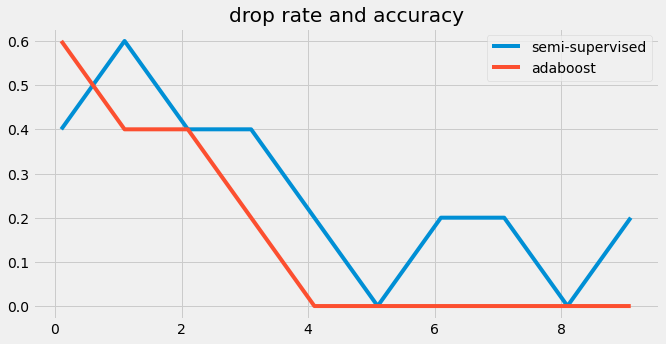

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')#画图风格
x=(np.arange(10)+1/10)
unit=1/5
y=(np.array([4,5,4,4,3,2,3,3,2,3])-2)*unit
y2=(np.array([5,4,4,3,2,2,2,2,2,2])-2)*unit
plt.figure(figsize=(10,5))
plt.plot(x,y,label='semi-supervised')
plt.plot(x,y2,label='adaboost')
plt.legend(loc='upper right')
plt.title('drop rate and accuracy')
plt.show()